<img src="https://teaching.bowyer.io/SDSAI/0/img/IMPERIAL_logo_RGB_Blue_2024.svg" alt="Imperial Logo" width="500"/><br /><br />

Supervised Learning
==============
### SURG70098 - Surgical Data Science and AI
### Stuart Bowyer

## Intended Learning Outcomes
1.  Understand what distinguishes supervised learning
1.  Understand when to use regression and classification models
1.  Be able to explain and apply basic regression and classification models to 'real-world' data
1.  Be able to fairly and meaningfully evaluate the performance of different supervised learning models

## Session Outline
1.  [Introduction to Supervised Machine Learning](#introduction_to_supervised_machine_learning)
1.  [Regression Models](#regression_models)
1.  [Classification Models](#classification_models)
1.  [Model Reliability and Reproducibility](#model_reliability_and_reproducibility)
1.  [Wrap Up](#wrap_up)

## MIMIC Dataset
The following code will load the datasets used in this lecture notes

In [14]:
%pip install pandas_gbq

import pandas as pd
import pandas_gbq

project_id = 'mimic-project-439314'  # @param {type:"string"}

df_day1_vitalsign = pandas_gbq.read_gbq("""
  SELECT *
  FROM `physionet-data.mimiciv_derived.first_day_vitalsign`
  LEFT JOIN (
    SELECT
      subject_id,
      stay_id,
      gender,
      race,
      admission_age,
      dod IS NOT NULL AS mortality
    FROM
      `physionet-data.mimiciv_derived.icustay_detail`
  )
  USING(subject_id, stay_id)
  LEFT JOIN (
    SELECT
      stay_id,
      AVG(weight) as weight
    FROM
      `physionet-data.mimiciv_derived.weight_durations`
    GROUP BY
      stay_id
  )
  USING(stay_id)
  LEFT JOIN (
    SELECT
      stay_id,
      CAST(AVG(height) AS FLOAT64) AS height
    FROM
      `physionet-data.mimiciv_derived.height`
    GROUP BY
      stay_id
  )
  USING(stay_id)
  WHERE heart_rate_mean IS NOT NULL
  LIMIT 10000
""", project_id=project_id)

/nix/store/na2a6spzlqg0rrgz8462bla7hxvygjcq-python3-3.11.9/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


/nix/store/l29r3cpnmjx97k44da7p1yms00jlcanv-python3.11-google-cloud-bigquery-3.23.0/lib/python3.11/site-packages/google/cloud/bigquery/table.py:2365: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


# Introduction to Supervised Machine Learning

## What is Supervised Learning

Creating a model based on a labelled set of data that can be used to predict something about future (unlabelled) data

![ML illustration](https://teaching.bowyer.io/SDSAI/3/img/Illustrations-SDSAI-03_ML-Foundations.svg)

## Stages in the Supervised Learning Process
1.  (Data Acquisition)
1.  (Data Preparation)
1.  Training
1.  Validation/Evaluation
1.  Deployment/Use

## Regression vs Classification

*   **Regression:** Supervised learning that predicts a continuous value output based on one or more features
*   **Classification:** Supervised learning that predicts a categorical value output based on one or more features

![Regression vs Classification](https://teaching.bowyer.io/SDSAI/4/img/Illustrations-SDSAI-04_Regression-vs-Classificaiton.svg)

## Example Uses of Supervised Learning

| Regression | Classification |
| ---------- | -------------- |
| Predict surgical procedure duration (Linear Regression) - https://doi.org/10.3389/fmed.2017.00085 | Predict risk of postoperative pulmonary complications (Logistic Regression/Boosted Trees) - https://doi.org/10.1016/S2589-7500(24)00065-7 |
| Predict FEV1 and FVC from chest x-ray (Deep NN) - https://doi.org/10.1016/S2589-7500(24)00113-4 | Identify (and rule out) patients with suspected myocardial infarction (Logistic Regression) - https://doi.org/10.1016/S2589-7500(24)00191-2 |
| Predicting length of stay after appendectomy surgery (Linear Regression) - https://doi.org/10.1186/s12911-022-01884-9 | Post surgery mortality prediction (Boosted Trees) - https://doi.org/10.3390/bioengineering8020022 |



# Regression Models
*   Supervised learning that predicts a continuous value output based on one or more features
*   Learns the relationship between feature values and an output value

## Linear Regression
Linear regression is a long standing statistical method for regression modelling

It has the following equation simplified equation univariate model (i.e. the equation for a straight line)
$$y = mx + c$$

where:
*   y is the predicted output
*   x is the feature input
*   m is the slope of the relationship
*   c is the relationship's intercept

### Worked Example
*   Assume we want to predict a patient's weight, given their height
*   Here are scatter and density plots for the available data from MIMIC-IV

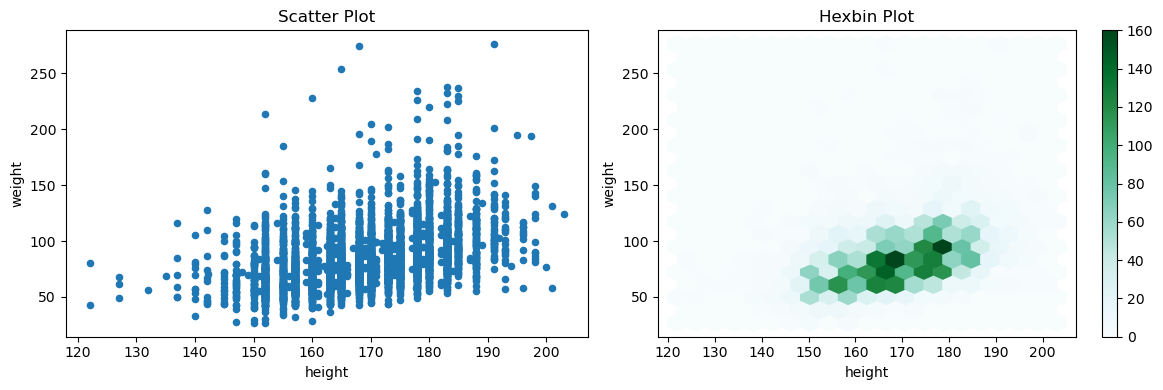

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Scatter Plot')
df_day1_vitalsign.plot.scatter('height', 'weight', ax=axes[0])
axes[1].set_title('Hexbin Plot')
df_day1_vitalsign.plot.hexbin('height', 'weight', gridsize=20, ax=axes[1])
plt.tight_layout()
plt.show()

*   Our linear regression equation becomes:

$$ weight = m \times height + c$$

*   **How do we calculate the gradient, $m$, and the intercept, $c$ ?**

### Solving for the Model Parameters
*   While solving this equation for pair of points is trivial (GCSE maths)
*   The challenge here is that for typical (imperfect) data, there is no single line that goes through all points
*   The problem becomes an optimisation problem ...
    *   i.e. find a line that minimises the prediction error
    *   Specifically, minimises the sum of the square of all errors

![OLS Error](https://teaching.bowyer.io/SDSAI/4/img/Illustrations-SDSAI-04_OLS.svg)

### Ordinary Least Squares
The Python function we use to model, relies on a method called 'Ordinary Least Squares'

The cost function it tries to minimise is:
$$S(b) = \sum_{i=1}^n (y_i - x_i ^T b)^2$$

where:
*   $x_i$ is the feature values of the $i$-th observation
*   $y_i$ is the $i$-th output values
*   $b$ is a candidate for the linear model parameters

Which can be solved using linear algebra:
$$S(b) = (X^TX)^{-1}X^Ty$$


### Python Implementation in `scikit-learn`

In [40]:
# Import the linear regression function from sklearn
from sklearn.linear_model import LinearRegression

# Prepare our data
#  - first remove any nan values as LR cannot work with them (if not already cleaned)
data = df_day1_vitalsign.dropna(subset=['height', 'weight'])
X = data[['height']]     # Note: Double brackets to maintain X as a DataFrame
Y = data['weight']       # Single bracket for a Series

# Create the model
model = LinearRegression()

# Train (fit) the model
model.fit(X,Y)

# Print model coefficients
print(f'Slope:     {model.coef_[0]}')
print(f'Intercept: {model.intercept_}')

Slope:     0.9683731292903554
Intercept: -78.72472270813638


### Predicting and Plotting the Model
*   The trained model can be used to predict (new) values with the `.predict()` method

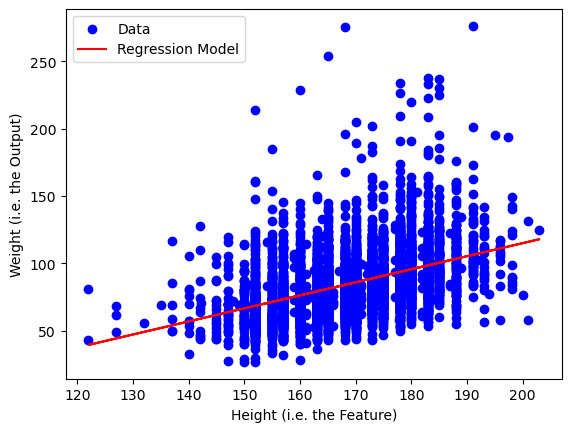

In [47]:
# Make predictions on the entire range of X values
Y_pred = model.predict(X)

# Plot the scatter plot of the data
plt.scatter(X, Y, color='blue', label='Data')

# Plot the regression line
plt.plot(X, Y_pred, color='red', label='Regression Model')

# Add labels and a legend
plt.xlabel('Height (i.e. the Feature)')
plt.ylabel('Weight (i.e. the Output)')
plt.legend()

# Show the plot
plt.show()

### Assumptions
*   The model assumes the feature values and output value are **linearly** related
*   The residual error ($\epsilon$) is normally distributed
*   Features are not multicolinear (i.e. highly correlated)

### Multivariate Linear Regression
*   **Note** that we are have only considered univariate linear regression (i.e. model with a single feature)
*   In practice, most of the time you will have several features and perform multivariate linear regression
*   You will explore this in the tutorial exercises

## Model Evaluation in Regression
How do you know if your regression model is a good predictor?

How might you quantify the model's performance?

### Mean Squared Error and Root Mean Squared Error
*   The 'mean squared error' (MSE) is a common metric for how 'good' a regression predictor is

$$mse = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

*   It is common to square root the MSE to get a metric with units that match the output of the model
*   This is called the 'root mean squared error (RMSE)

$$rmse = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

#### Python Implementation in `scikit-learn`

In [51]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

mse = mean_squared_error(Y, Y_pred)
print(f'Mean Squared Error:      {mse} kg2')

rmse = root_mean_squared_error(Y, Y_pred)
print(f'Root Mean Squared Error: {rmse} kg')

Mean Squared Error:      511.8104482250559 kg2
Root Mean Squared Error: 22.623228068183725 kg


### R-squared and Residual Analysis
*   R-squared is a metric the describes how much of the the variability in an output is 'described' by the model
    *   i.e. a perfect model would predict all of the variability in an output, and would have an R-squared of 1
*   Residual analysis is used to explore the residual error in a model and validate that it satisfies the models assumption
*   There are items in the reading list for you to explore these concepts

## Model Validation
Can you see any possible issue with using metrics to validate the quality of a model's 'fit' in the way we did it?

Hint - what data are we using to train the model, and what data are we using to compute the metrics?

### Training and Testing on the Same Data Set
*   A model validated on it's training data can:
    *   Easily overfit the data and will not generalise to new inputs
    *   Overestimate the model's performance
*   What do you think is the solution to this?

![Illustration of data modelling](https://teaching.bowyer.io/SDSAI/3/img/Illustrations-SDSAI-03_Model-Overfitting.svg)

### Train / Test Splitting
*   Solution is to split the dataset into:
    *   **Training set** - to train the model
    *   **Testing set** - to validate the trained model on unseen data
*   To avoid bias due this split should be randomly assigned
*   Typically splits will be 80/20 or 70/30 for Training/Testing

![Illustration of data modelling](https://teaching.bowyer.io/SDSAI/4/img/Illustrations-SDSAI-04_Train-Test-Split.svg)

#### Python Implementation in `scikit-learn`

In [61]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
#   - with 20% in the test
#   - with 123 as the randomisation seed
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

print(f'Samples in full data set:     {len(X)}')
print(f'Samples in training data set: {len(X_train)} ({100*len(X_train)/len(X)} %)')
print(f'Samples in testing data set:  {len(X_test)} ({100*len(X_test)/len(X)} %)')

Samples in full data set:     4379
Samples in training data set: 3503 (79.99543274720256 %)
Samples in testing data set:  876 (20.004567252797443 %)


#### Train, Predict and Evaluate

In [63]:
# Train the model on the training set
model.fit(X_train,Y_train)

# Use the model to predict values for the testing set
Y_pred = model.predict(X_test)

# Evaluate the metrics
mse = mean_squared_error(Y_test, Y_pred)
print(f'Mean Squared Error:      {mse} kg2')

rmse = root_mean_squared_error(Y_test, Y_pred)
print(f'Root Mean Squared Error: {rmse} kg')

Mean Squared Error:      532.7518734142269 kg2
Root Mean Squared Error: 23.08141835793951 kg


**These are slightly higher than they were for the self train test example earlier**

### Does train/test splitting guarantee not to overfit the data?

### If not, what could we do to mitigate this?

### Cross Validation
*   To mitigate the risk of non-representative splits in train/test data we can use 'cross validation'
*   Simplistically, cross validation involves repeatedly train/testing the data on several different segregations of the data


#### k-fold Cross Validation
*   k-fold cross validation is a very widely uses cross validation approach
*   The method is:
    *   Split your data into k different sub sets - called folds
    *   Train your model on all but one fold and test/validate on the remaining fold
    *   Repeat this process k times so that each fold is used as the testing set once
    *   Combine your validation metrics

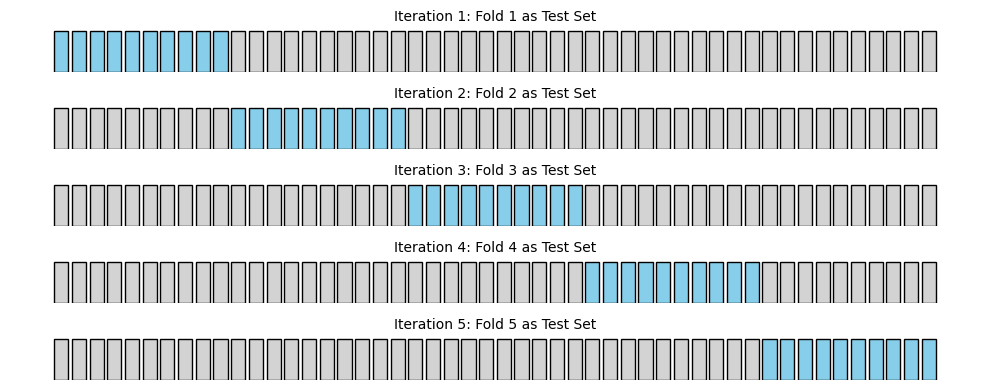

In [81]:
# *ChatGPT Generated*
# This code just generates an illustration of k-fold cross validation
# You do not need to understand it

import matplotlib.pyplot as plt
import numpy as np

# Parameters for the illustration
k = 5  # Number of folds
n_samples = 50  # Total number of samples

# Generate a dataset as a grid of samples
data = np.arange(n_samples)

# Split the data into k folds
fold_size = n_samples // k

# Create the illustration
fig, axes = plt.subplots(k, 1, figsize=(10, 4))

for i in range(k):
    # Reset the colors for each fold
    colors = np.array(['lightgray'] * n_samples)
    
    # Mark the current test fold in a different color
    colors[i * fold_size:(i + 1) * fold_size] = 'skyblue'
    
    # Plot the data with different colors for training and testing
    axes[i].bar(data, 1, color=colors, edgecolor='black')
    axes[i].set_title(f"Iteration {i + 1}: Fold {i + 1} as Test Set", fontsize=10)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


#### Python Implementation in `scikit-learn`

In [83]:
from sklearn.model_selection import cross_val_score

# Perform the cross validation
#   - pass it the model you want to validate (e.g. the LinearRegression())
#   - pass the full feature and output datasets
#   - specify the number of folds (e.g. 5)
#   - specify the scoring method you want (e.g. RMSE)
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_root_mean_squared_error')

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Score:              {scores.mean()}')

Cross-Validation Scores: [-27.34798278 -22.96258907 -22.01208489 -20.18402581 -19.84045977]
Mean Score:              -22.469428464632717


**Note - `scikit-learn` generally tries to maximise a metric/score, therefore we are using the NEGATIVE of the RMSE**

#### Alternative Approaches
*   Stratified k-fold Cross-Validation
    *   Used for imbalanced classification problems (e.g. trying to classify mortality where the rate is low)
    *   Modified k-fold where folds are adjusted to ensure each fold has a proportional representation of classes
*   Leave-One-Out Cross-Validation (LOOCV)
    *   Special case where k is the number of samples in the dataset
    *   Therefore, each sample is used once as a test set, and the rest as the training set

### Comments on Validation
*   Always ensure that you are splitting your data fairly and independently to prevent training data leakage
*   Prospective multi-centre validation is the gold-standard, that very few models achieve

## Regularisation

What is Regularisation?
*   Regularisation is a technique used in regression to penalise models with many large coefficients
*   Effectively, it tries to make the model more efficient with its features
*   Reducing the complexity of the model reduces the likelihood of overfitting
*   This can help find the model a balance of underfitting and overfitting

Common Methods
*   Lasso Regression (L1 Regularisation) - reduces the magnitude of coefficients
*   Ridge Regression (L2 Regularisation) - reduces the sum of squared coefficients
*   Elastic Net Regression - combines Lasso and Ridge regression

**Further reading on this is included in the reading list**

## Other Regression Methods
*   There are several other models that can be used for regression
*   If you want to model something with regression that is non-linear, you should explore these
    *   Polynomial regression - where the relationship is modelled as an nth degree polynomial
    *   Neural networks - which we will cover next week
    *   Decision tree/random forest
    *   Bayesian regression

# Classification Models
*   Supervised learning that predicts a discrete/categorical value output based on one or more features
*   Learns the relationship between feature values and an output category

## Logistic Regression
*   A classification model used to predict the probability of a **binary** outcome
*   It is based on Linear Regression but uses the logistic function to limit the output between 0 and 1
*   By applying a probability threshold (typically 0.5), the logistic function output can give the binary prediction

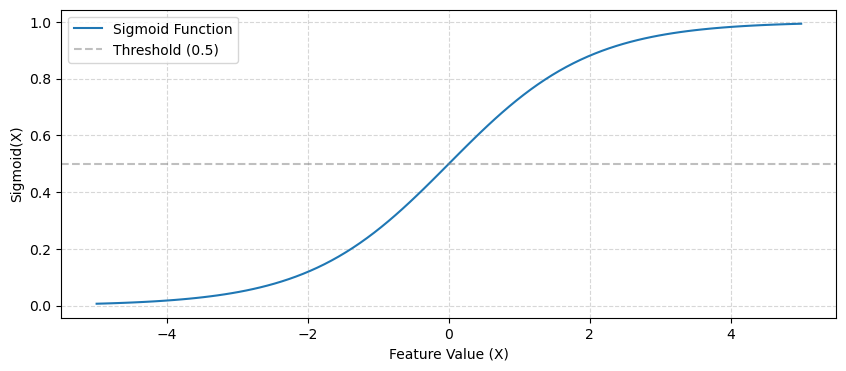

In [92]:
# *ChatGPT Generated*
# This code just generates an illustration of a sigmoid function
# You do not need to understand it

import numpy as np
import matplotlib.pyplot as plt

# Generate x values from -5 to 5
x_values = np.linspace(-5, 5, 100)
y_values = 1 / (1 + np.exp(-x_values))

# Plot the sigmoid function
plt.figure(figsize=(10, 4))
plt.plot(x_values, y_values, label='Sigmoid Function')
plt.xlabel('Feature Value (X)')
plt.ylabel('Sigmoid(X)')
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Threshold (0.5)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Python Implementation in `scikit-learn`

In [130]:
from sklearn.linear_model import LogisticRegression

# # Prepare our data
# #  - first remove any nan values as LR cannot work with them (if not already cleaned)
data = df_day1_vitalsign.dropna(subset=['admission_age', 'mortality'])
X = data[['admission_age']]
Y = data['mortality']

# Create the model
model = LogisticRegression()

# Train (fit) the model
model.fit(X, Y)

**Note - the ceofficients of a logistic regression model cannot be so easily interpreted as they were for linear regression**

### Predicting and Plotting the Model
*   The trained model can be used to predict (new) probablities with the `.predict_proba()` method
*   Or predict (new) classifications with the `.predict()` method

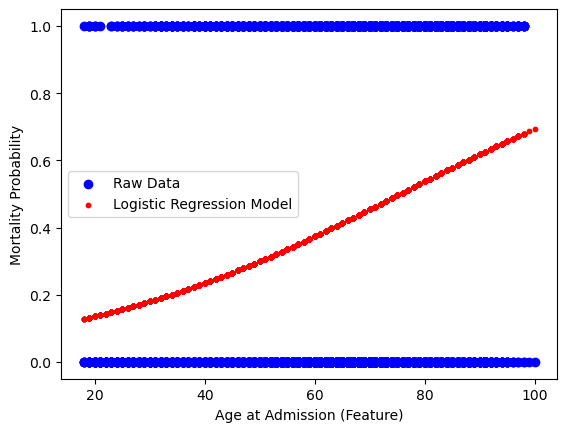

In [148]:
# Calculate the predicted probabilities
Y_prob = model.predict_proba(X)[:, 1]

# Plot the age vs mortality points
plt.scatter(X, Y, color='blue', label='Raw Data')

# Plot the logistic regression model
plt.scatter(
    X, Y_prob, color='red', s=10,
    label='Logistic Regression Model'
)

# Formatting
plt.xlabel('Age at Admission (Feature)')
plt.ylabel('Mortality Probability')
plt.legend()
plt.show()

## Model Evaluation in Classification
Unlike in regression, a classification is either 100% correct or wrong; therefore, measuring the residual error is less helpful

**What method would you use to evaluate a classification model?**

### Confusion Matrix
*   The confusion matrix is simply a tabulation of the counts for predicted against actual classifications

![Illustration of a confusion matrix](https://teaching.bowyer.io/SDSAI/4/img/Illustrations-SDSAI-04_Confusion-Matrix.svg)

#### Python Implementation in `scikit-learn`

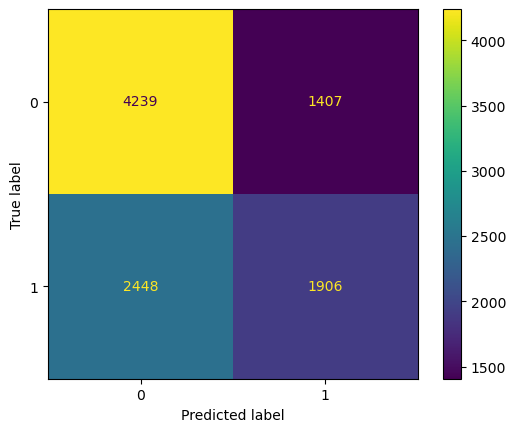

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the classes
Y_pred = model.predict(X)

# Compute the confusion matrix
cm = confusion_matrix(Y, Y_pred)

# Visualise the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Metrics
To compare and assess classifier predictions, the confusion matrix can be converted into a range of metrics (there are many more)

#### Accuracy
*   **Definition**: Proportion of correctly classified instances over the total number of instances
*   **Formula**: (TP + TN) / (TP + TN + FP + FN)

#### Precision (Positive Predictive Value)
*   **Definition**: Proportion of true positives out of all predicted positives
*   **Formula**: TP / (TP + FP)

#### Recall (Sensitivity/True Positive Rate)
- **Definition**: Proportion of true positives out of all actual positives
- **Formula**: TP / (TP + FN)

#### F1 Score
- **Definition**: Harmonic mean of precision and recall, useful for imbalanced datasets
- **Formula**: 2 * (Precision * Recall) / (Precision + Recall)

#### Python Implementation in `scikit-learn`

In [159]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
f1 = f1_score(Y, Y_pred)

print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

Accuracy:  0.61
Precision: 0.58
Recall:    0.44
F1 Score:  0.50


#### Which of these metrics is the best?

#### For each, can you think of any occurrences in which they would give misleading results?

### ROC Curves
*   The challenges of imbalanced data, and the ability to 'hack' metrics by adjusting a model's threshold leads to the use of ROC curves
*   This is a plot of the 'true positive rate' (TRP) against the 'false positive rate' (FPR) for varying thresholds
    *   TPR = TP / (TP + FN)
    *   FPR = FP / (FP + TN)
*   The area under the ROC curve (ROC-AUC), is commonly used as an evaluation metric
    *   ROC AUC close to 1 identifies a good classifier
    *   ROC AUC close to 0.5 indicates a poor classifier (effectively random guessing)

#### Python implementation in `scikit-learn`

ROC AUC:  0.64


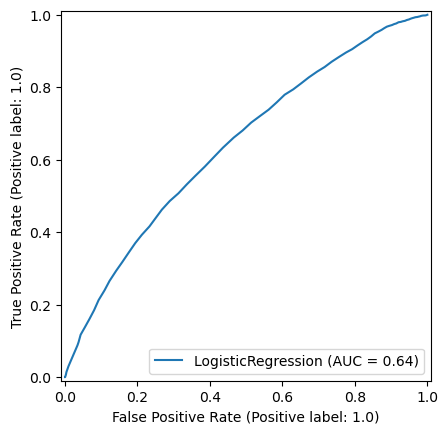

In [171]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

# Calculate the ROC-AUC
auc_score = roc_auc_score(Y, Y_prob)
print(f"ROC AUC:  {auc_score:.2f}")

# Plot the ROC curve
RocCurveDisplay.from_estimator(model, X, Y)
plt.show()

*   In the bottom left corner, there is a low threshold, thus no patients are classified as True
*   In the top right corner, there is a high threshold, thus all patients are classified as True

## Other Classification Models
So far we have only looked at logistic regression, there are many other classification models

The most popular, Neural Networks, we will explore next week

## Support Vector Machines (SVM)
### What is it?
*   Training the model optimises the placement for (hyper-) planes that separate the classes
*   The model aims to separate the classes as far as possible

### Why use it?
*   Focus on separation means the model can generalise better than SVM
*   Non-linear boundaries can be class modelled by transforming the data into a higher dimensional spaces

### sklearn function
*   `sklearn.svm.SVC`

![Illustration of a SVM](https://teaching.bowyer.io/SDSAI/4/img/Illustrations-SDSAI-04_SVM.svg)

## Decision Trees
### What is it?
*   Decision trees are a tree-like structure where data is split into branches based on feature values, leading to classifications at the leaves

### Why use it?
*   Can model non-linear features
*   Output model is human interpretable

### sklearn function
*   `sklearn.tree.DecisionTreeClassifier`

![Illustration of a decision tree](https://teaching.bowyer.io/SDSAI/4/img/Illustrations-SDSAI-04_Decision-Tree.svg)

## K-Nearest Neighbors (KNN)
### What is it?
*   This classifier predicts an inputs class by looking at the 'k' closest data points (neighbors) in the training data

### Why use it?
*   Can model non-linear features
*   Simple to understand and implement

### sklearn function
*   `sklearn.neighbors.KNeighborsClassifier`

![Illustration of a decision tree](https://teaching.bowyer.io/SDSAI/4/img/Illustrations-SDSAI-04_KNN.svg)

# Tutorial Exercises

## Exercise 4.1 - Multivariate Linear Regression
In the linear regression example in this lecture we only considered a single feature to predict weight. Univariate models are very simple and unlikely to have good performance for problems of any complexity.

Write some code to improve the performance of your weight prediction based on any other (one or two only) columns in the `df_day1_vitalsign` data set that you hypothesise will improve the performance. You can engineer a new feature if you think it necessary.

Validate and compare the performance of your multivariate linear regression model to the univariate one created in the lecture.

## Exercise 4.2 - Multivariate Classification and Validation
For simplicity, we used the same data set to train and test the classification models we built in this lecture. **This is not good practice**. You should always use Train/Test splitting and/or cross validation, as was demonstrated for regression.

The model we developed was also very simple and only used age to predict mortality. As in exercise 4.1, you should use your clinical knowledge to hypothesise about several other features from the `df_day1_vitalsign` data set that might impact mortality. You should then add these to the logisitic regression classifier and perform a full validation of its performance.

Again, you should compare the performance of your multivariate model to the univariate model we demonstrated in the lecture.

## Exercise 4.3 - Classification Model Comparison
Once you have selected your best combination of features for predicting mortality in exercise 4.2, you should compare the performance of your features on logistic regression, SVM, decision tree, and KNN classifiers.

Which of the four models we have looked at gives the best performance?

You should do additional reading around these methods to try and understand why each of them performs the way they do and how they are helpful.

## Bonus Exercise 4.4 - Data Normalisation and Standardisation
Last lecture we looked at data normalisation and standardisation. Try applying one of these methods to your features and compare the performance of your classifiers with and without it - particularly KNN.

What would explain the difference in performance with normalisation or standardisation?

# Wrap Up
*   We have focused in this lecture on the end-to-end modelling process encouraging good practice in validation
*   To fully understand the models you will need to try applying them yourself

## Before Next Session

*   Complete the tutorial exercises

### New Material from the Reading List
*   R-squared and Residual Analysis
*   Regularisation methods
*   Detailed look at SVM, decision tree, and KNN classifiers